# Taller Deep Learning Obligatorio



## Participantes

* Martin Martinez: 344567

* Rodrigo Paz: 325277




In [1]:
!pip install albumentations[imgaug] opencv-python

In [2]:
# Importamos todas las dependencias
import sys

sys.path.append('/kaggle/input/codebase1')

from matplotlib import pyplot as plt
import os
from pathlib import Path
from segmentation_dataset import SegmentacionDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from typing import Callable, Optional
import numpy as np
from u_net import UNet
from utils import (
    train,
    plot_taining,
    rle_encode
)


/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Fijamos la semilla para que los resultados sean reproducibles

SEED = 34

torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [4]:
#Declaramos todas las variables globales y los hiper parametros del modelo

DEVICE = "cpu"

if torch.cuda.is_available():

    DEVICE = "cuda"

elif torch.backends.mps.is_available():

    DEVICE = "mps"



NUM_WORKERS = 0 if DEVICE == "mps" else max(os.cpu_count() - 1, 1)  #número de workers para cargar los datos a menos que estemos corriendo en Mac OS

BATCH_SIZE = 8  # tamaño del batch


print(f"Device: {DEVICE}")

print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Dataset

Los datos provistos en la competencia de Kaggel, para cada muestra se tiene la imagen en formato PNG, en un tamaño fijo 800x800 y por separado tenemos en otra carpeta el resultado esperado de esta muestra. Crearemos un Dataset propio para cargar los X, Y

In [6]:
DATA_DIR = 'tdl-segmentacion'
# TRAIN_DATA_DIR = Path(f'/kaggle/input/dataset/{DATA_DIR}/train')
TRAIN_DATA_DIR = Path('small-segmentation/train')
# TRAIN_DATA_DIR = Path('tdl-segmentacion/train')

IMAGE_SIZE = (400, 400) #Dimensiones de la imagen tiene que ser multiplos


def create_train_val_datasets(
    validation_percentage: float = 0.2
):

    full_train_dataset = SegmentacionDataset(
        root_dir = TRAIN_DATA_DIR,
        image_size=IMAGE_SIZE,
        load_mask = True
    )

    return full_train_dataset, random_split(
        full_train_dataset,
        [1 - validation_percentage, validation_percentage],
        generator = torch.Generator().manual_seed(SEED)
    )


_, (test_dataset, _) = create_train_val_datasets()

test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )

images, masks = next(iter(test_loader))
image1 = images[1]
mask = masks[1]
print(f'{type(image1)=},{type(mask)=}')
print(f'{image1.shape=},{mask.shape=}')

Valor de la media y desviación estándar leídos del archivo
type(image1)=<class 'torch.Tensor'>,type(mask)=<class 'torch.Tensor'>
image1.shape=torch.Size([3, 400, 400]),mask.shape=torch.Size([1, 400, 400])


In [7]:
#Analizamos la imagen y la mascara con sus valores

print(f'image cantidad de unos:{(image1 == 1 ).sum().item()}')

print(f'image cantidad de ceros:{(image1 == 0).sum().item()}')

print(f'image Cantidad de valores que no son cero ni uno:{((image1 > 0) & (image1 < 1)).sum().item()}')

print(f'image Cantidad de valores menores que cero:{(image1 < 0).sum().item()}')

print(f'image Cantidad de valores mayores que 1:{(image1 > 1).sum().item()}')

print(f'image Valores unicos :{ image1.unique()}')



print(f'mask cantidad de unos:{(mask == 1 ).sum().item()}')

print(f'mask cantidad de ceros:{(mask == 0).sum().item()}')

print(f'mask Cantidad de valores que no son cero ni uno:{((mask > 0) & (mask < 1)).sum().item()}')

print(f'mask Cantidad de valores menores que cero:{(mask < 0).sum().item()}')

print(f'mask Cantidad de valores mayores que 1:{(mask > 1).sum().item()}')

print(f'mask Valores unicos :{ mask.unique()}')

image cantidad de unos:0
image cantidad de ceros:0
image Cantidad de valores que no son cero ni uno:84848
image Cantidad de valores menores que cero:359578
image Cantidad de valores mayores que 1:35574
image Valores unicos :tensor([-2.2187e+00, -2.2028e+00, -2.1710e+00, -2.1551e+00, -2.1392e+00,
        -2.1233e+00, -2.1074e+00, -2.0916e+00, -2.0757e+00, -2.0598e+00,
        -2.0439e+00, -2.0280e+00, -2.0121e+00, -1.9962e+00, -1.9803e+00,
        -1.9644e+00, -1.9485e+00, -1.9326e+00, -1.9168e+00, -1.9009e+00,
        -1.8850e+00, -1.8691e+00, -1.8532e+00, -1.8373e+00, -1.8214e+00,
        -1.8055e+00, -1.7896e+00, -1.7737e+00, -1.7578e+00, -1.7420e+00,
        -1.7261e+00, -1.7102e+00, -1.6943e+00, -1.6784e+00, -1.6720e+00,
        -1.6625e+00, -1.6566e+00, -1.6466e+00, -1.6412e+00, -1.6377e+00,
        -1.6307e+00, -1.6218e+00, -1.6148e+00, -1.6104e+00, -1.6059e+00,
        -1.5989e+00, -1.5900e+00, -1.5830e+00, -1.5796e+00, -1.5741e+00,
        -1.5672e+00, -1.5642e+00, -1.5582e+00,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2186856..2.2078152].


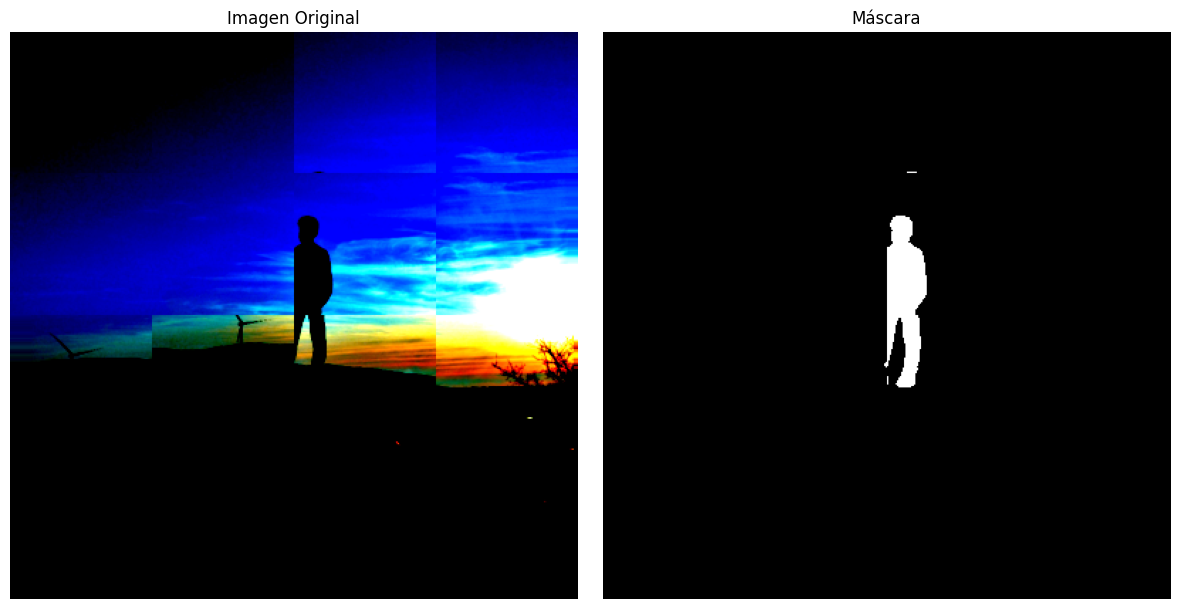

In [8]:
# Creamos una funcion que nos muestre la imagen original y su mascara

def plot_image_with_mask(

    image,

    mask

):

    """

    Muestra la imagen original y a su lado su respectiva mascara. Se asume que tanto la imagen y la mascara tienen el mismo tamaño

    """

    image_np = image.permute(1, 2, 0).numpy()

    mask_np = mask.squeeze(0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Mostrar la imagen original

    axs[0].imshow(image_np, vmin=0, vmax=1)

    axs[0].set_title("Imagen Original")

    axs[0].axis('off')

    axs[1].imshow(mask_np, cmap='gray', vmin=0, vmax=1)

    axs[1].set_title("Máscara")

    axs[1].axis('off')

    plt.tight_layout()

    plt.show()



plot_image_with_mask(image1, mask)

### Generamos el modelo de U-Net

In [9]:
from dice_loss import DiceLoss


model = UNet(input_channel=3, out_channel=1).to(DEVICE)
LR = 0.00005

CRITERION = nn.BCELoss().to(DEVICE)

# CRITERION = DiceLoss().to(DEVICE)

def log(epoch, train_loss, val_loss):
    print({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})


full_train_dataset, (train_dataset, val_dataset) = create_train_val_datasets()

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

train_errors_ln_da, val_errors_ln_da, epochs_train = train(
    model = model,
    optimizer = optim.Adam(model.parameters(), lr=LR),
    criterion = CRITERION,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    patience = 5,
    epochs = 200,
    log_fn = log,
    log_every=1
)
print(f'Best epoch: {epochs_train}')

Valor de la media y desviación estándar leídos del archivo
{'epoch': 0, 'train_loss': 0.7115806937217712, 'val_loss': 0.7096155881881714}
{'epoch': 1, 'train_loss': 0.6687494814395905, 'val_loss': 0.7117242217063904}
{'epoch': 2, 'train_loss': 0.655308872461319, 'val_loss': 0.7135295867919922}
{'epoch': 3, 'train_loss': 0.6279847621917725, 'val_loss': 0.7149479389190674}
{'epoch': 4, 'train_loss': 0.6004120409488678, 'val_loss': 0.7174333333969116}
{'epoch': 5, 'train_loss': 0.5731099545955658, 'val_loss': 0.7222764492034912}
Detener entrenamiento en la época 5, la mejor pérdida fue 0.70962 en la época 1
Best epoch: 1


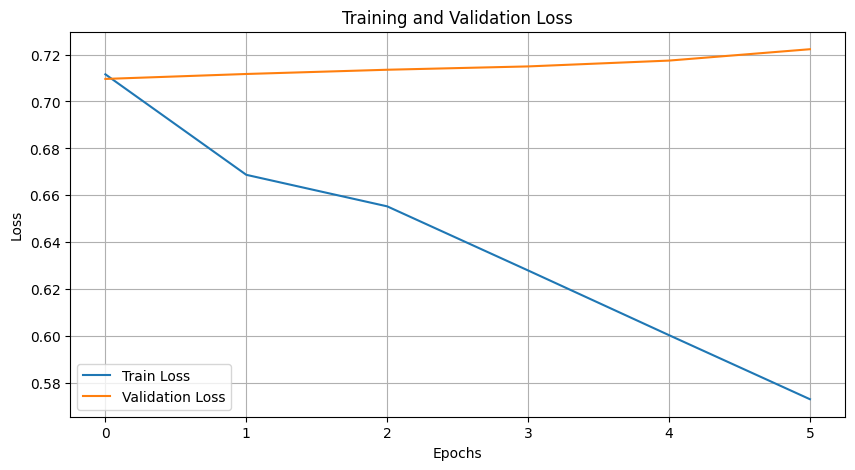

/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
accuracy = 0.37578333333333336
f1_score = 0.2052839428850635
precision = 0.1412131136111111
recall = 0.37578333333333336


/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
from utils import segmentation_classification_report

plot_taining(train_errors_ln_da, val_errors_ln_da)
(accuracy, f1_score, precision, recall) = segmentation_classification_report(model, val_loader, DEVICE)
print(f'Classification Report:')
print(f'{accuracy = }')
print(f'{f1_score = }')
print(f'{precision = }')
print(f'{recall = }')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2186856..2.2078152].


image1.shape=torch.Size([3, 400, 400]),real_mask.shape=torch.Size([1, 400, 400])
cantidad de unos en real_mask:47263


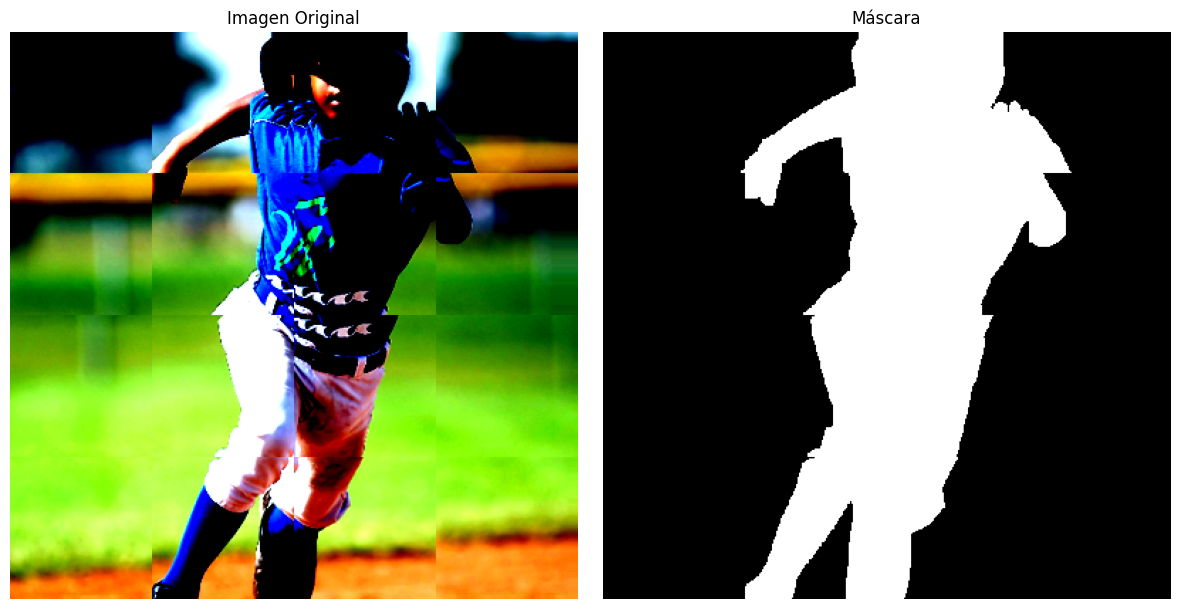

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2186856..2.2078152].


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
image1.shape=torch.Size([3, 400, 400]),predicted_mask.shape=torch.Size([1, 400, 400])
cantidad de unos:0
cantidad de ceros:160000
delta=29.53937530517578


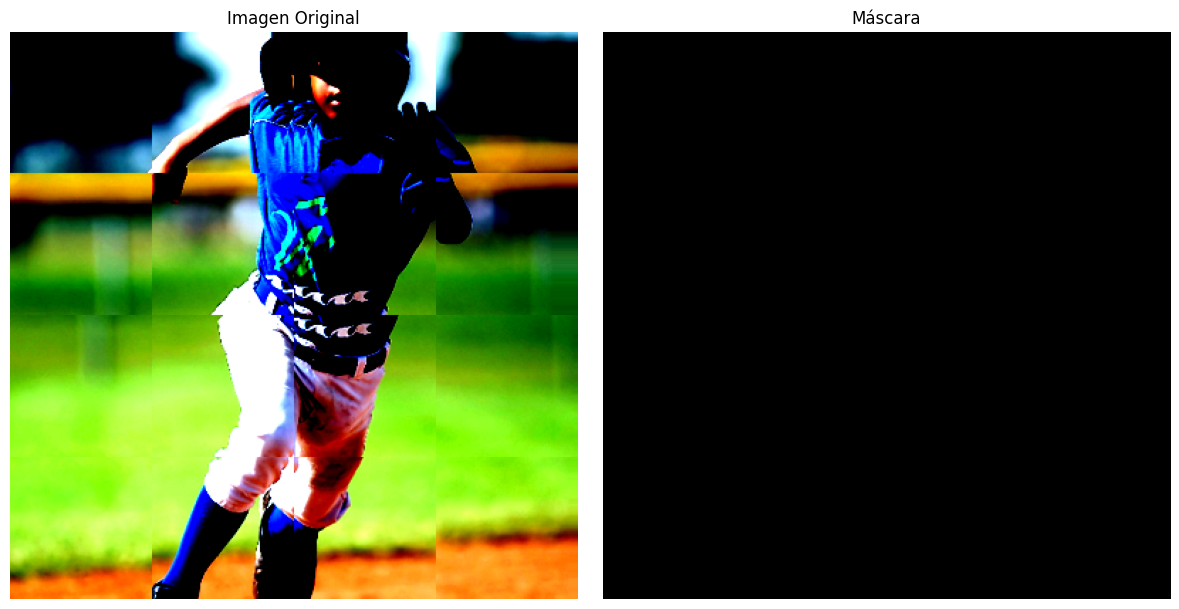

In [16]:
#Comprobamos el modelo a ver como entrenó con una imagen y vemos su salida

images, masks = next(iter(train_loader))
image1 = images[0]
real_mask = masks[0]
print(f'{image1.shape=},{real_mask.shape=}')
print(f'cantidad de unos en real_mask:{(real_mask > 0).sum().item()}')
plot_image_with_mask(image1, real_mask)
model.eval()

with torch.no_grad():
    predicted_mask = model(image1.unsqueeze(0).to(DEVICE))
    predicted_mask = predicted_mask.squeeze(0).cpu()
    predicted_mask = (predicted_mask > 0.5).float() #Binarizamos la mascara
    print(predicted_mask)

print(f'{image1.shape=},{predicted_mask.shape=}')
print(f'cantidad de unos:{(predicted_mask == 1 ).sum().item()}')
print(f'cantidad de ceros:{(predicted_mask == 0 ).sum().item()}')
delta = CRITERION(real_mask, predicted_mask).item()
print(f'{delta=}')
plot_image_with_mask(image1, predicted_mask)


### Entrenamos de nuevo con la misma cantidad de épocas y usando todo el dataset (train + validation)

In [12]:
from utils import final_train

model = UNet(input_channel=3, out_channel=1).to(DEVICE)

def fina_train_log(epoch, train_loss):
    print({"epoch": epoch, "train_loss": train_loss})

full_train_dataloader = DataLoader(
    full_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

final_train(
    model = model,
    optimizer = optim.Adam(model.parameters(), lr=LR),
    criterion = CRITERION,
    train_loader = full_train_dataloader,
    device = DEVICE,
    epochs = epochs_train,
    log_fn = fina_train_log,
    log_every=1
)

{'epoch': 0, 'train_loss': 0.7037158807118734}
Epoch [1/1], Loss: 0.7037


In [13]:
# Guardamos todos los pesos del modelo en un archivo
torch.save(model.state_dict(), 'unet_weights.pth')

In [14]:
# Corremos el modelo en el conjunto de test
# TEST_DATA_DIR = Path(f'/kaggle/input/dataset/{DATA_DIR}/test')
TEST_DATA_DIR = Path(f'small-segmentation/test')
# TEST_DATA_DIR = Path(f'tdl-segmentacion/test')

test_dataset = SegmentacionDataset(
        root_dir = TEST_DATA_DIR,
        image_size=IMAGE_SIZE,
        load_mask = False
    )

test_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

model.eval()
model.to(DEVICE)
with torch.no_grad():
    results = []
    for i, images in enumerate(test_dataloader):
        images = images.to(DEVICE)
        predicted_masks = model(images)
        # predicted_masks: [BATCH_SIZE, 1, *IMAGE_SIZE]
        predicted_masks = F.interpolate(predicted_masks, size=(800, 800), mode='bilinear', align_corners=False) #Tenemos que convertir la salida a 800x800
        predicted_masks = predicted_masks.squeeze(1).cpu()
        # predicted_masks: [BATCH_SIZE, 800, 800]
        predicted_masks = (predicted_masks > 0.5).float()
        id = f"{test_dataset.get_name(i)}"
        encoded_masks = rle_encode(predicted_masks)
        results.append((id, encoded_masks))
    print(len(results))

Valor de la media y desviación estándar leídos del archivo
8


In [15]:
#Guardamos las predicciones en un archivo para subir a Kaggle
import pandas as pd
submission_df = pd.DataFrame(results, columns=['id', 'encoded_pixels'])
submission_df['id'] = submission_df['id'].astype(str)
submission_df.to_csv("submission.csv", index=False)
print(submission_df.dtypes)


id                object
encoded_pixels    object
dtype: object
